# IAPR: Project ‒  Coin Counter


**Group ID:** 12

**Author 1 (sciper):** Vray Alexandre (310104)   
**Author 2 (sciper):** Aellen Edgar (311574)  
**Author 3 (sciper):** Robrdet Alexis (371391)   

**Release date:** 26.04.2024  
**Due date:** 29.05.2024 (11:59 pm)

In [1]:
import cv2
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

data_folder = 'data/train'

## Read data

In [2]:
data = pd.read_csv('data/train_labels.csv').sort_values(by='id')
data

,id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD
6,L1010277,1,0,0,0,0,0,0,1,0,1,2,0,0,0,0,0
10,L1010279,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0
0,L1010281,0,0,0,0,2,3,1,0,0,0,0,0,2,0,0,0
15,L1010283,0,0,0,1,0,0,0,1,0,2,1,0,1,0,0,0
8,L1010287,0,1,1,0,0,0,1,0,0,0,0,2,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,L1010515,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
74,L1010517,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
78,L1010521,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
80,L1010523,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1


In [7]:
def load_images_from_folder(folder):
    images = []
    for root, _, filenames in sorted(os.walk(folder)):
        for filename in sorted(filenames):
            img = cv2.imread(os.path.join(root, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
    return images

# Replace 'path_to_your_folder' with the path to the folder containing your images
x = load_images_from_folder(data_folder)
y = data.loc[:,'5CHF':].values

labels = data.loc[:,'5CHF':].columns

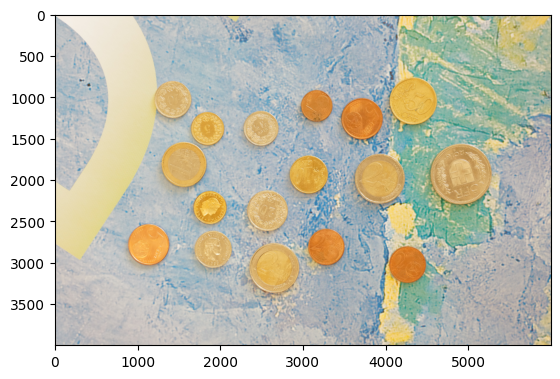

1 x 5CHF
1 x 0.5CHF
1 x 0.2CHF
2 x 0.1CHF
2 x 0.05CHF
2 x 2EUR
1 x 1EUR
1 x 0.5EUR
1 x 0.1EUR
2 x 0.05EUR
2 x 0.02EUR
1 x 0.01EUR


In [12]:
i = 30
plt.imshow(x[i])
plt.show()

for j in range(len(labels)):
    if y[i][j] != 0:
        print(y[i][j],'x',labels[j])

## 1. Localization

## 2. Feature extraction

## 3. Classification